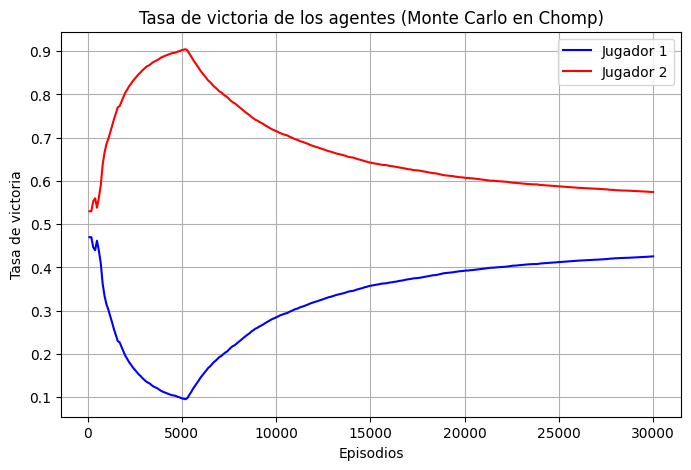

In [87]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

random.seed(3)
np.random.seed(3)

# ----------------------------
# Parámetros del entorno
# ----------------------------
ROWS = 4
COLS = 4
EPISODES = 30000
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.99

# ----------------------------
# Funciones del entorno Chomp
# ----------------------------
def initial_state():
    return tuple([COLS] * ROWS)

def is_terminal(state):
    return state[0] == 0

def get_possible_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(state[i]):
            actions.append((i, j))
    return actions

def apply_action(state, action):
    i, j = action
    new_state = list(state)
    for row in range(i, len(state)):
        new_state[row] = min(new_state[row], j)
    return tuple(new_state)

def choose_action(state, Q, epsilon):
    actions = get_possible_actions(state)
    if not actions:
        return None
    if random.random() < epsilon:
        return random.choice(actions)
    q_vals = [Q[(state, a)] for a in actions]
    max_q = max(q_vals)
    best_actions = [a for a, q in zip(actions, q_vals) if q == max_q]
    return random.choice(best_actions)

# ----------------------------
# Inicialización
# ----------------------------
Q1 = defaultdict(float)
Q2 = defaultdict(float)
returns_count1 = defaultdict(int)
returns_count2 = defaultdict(int)
epsilon1 = EPSILON_START
epsilon2 = EPSILON_START

win_counts_1 = 0
win_counts_2 = 0
win_rates_1 = []
win_rates_2 = []

# ----------------------------
# Entrenamiento
# ----------------------------
for episode in range(EPISODES):
    state = initial_state()
    episode_history_1 = []
    episode_history_2 = []
    player_turn = random.randint(0, 1)
    terminal = False

    while not terminal:
        if is_terminal(state):
            reward1, reward2 = (-1, 1) if player_turn == 0 else (1, -1)
            break

        if player_turn == 0:
            action = choose_action(state, Q1, epsilon1)
            if action is None:
                reward1, reward2 = -1, 1
                break
            next_state = apply_action(state, action)
            episode_history_1.append((state, action))

            if is_terminal(next_state):
                reward1, reward2 = -1, 1  # Jugador 1 pierde
                terminal = True
            else:
                state = next_state

        else:
            action = choose_action(state, Q2, epsilon2)
            if action is None:
                reward1, reward2 = 1, -1
                break
            next_state = apply_action(state, action)
            episode_history_2.append((state, action))

            if is_terminal(next_state):
                reward1, reward2 = 1, -1  # Jugador 2 pierde
                terminal = True
            else:
                state = next_state

        player_turn = 1 - player_turn

    # Actualización Monte Carlo (first-visit)
    visited1 = set()
    for (s, a) in episode_history_1:
        if (s, a) not in visited1:
            visited1.add((s, a))
            returns_count1[(s, a)] += 1
            Q1[(s, a)] += (reward1 - Q1[(s, a)]) / returns_count1[(s, a)]

    visited2 = set()
    for (s, a) in episode_history_2:
        if (s, a) not in visited2:
            visited2.add((s, a))
            returns_count2[(s, a)] += 1
            Q2[(s, a)] += (reward2 - Q2[(s, a)]) / returns_count2[(s, a)]

    if reward1 == 1:
        win_counts_1 += 1
    elif reward2 == 1:
        win_counts_2 += 1

    epsilon1 = max(EPSILON_MIN, epsilon1 * EPSILON_DECAY)
    epsilon2 = max(EPSILON_MIN, epsilon2 * EPSILON_DECAY)

    # Métricas cada 100 episodios
    if (episode + 1) % 100 == 0:
        win_rates_1.append(win_counts_1 / (episode + 1))
        win_rates_2.append(win_counts_2 / (episode + 1))

# ----------------------------
# Visualización
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates_1, label='Jugador 1', color='blue')
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates_2, label='Jugador 2', color='red')
plt.xlabel("Episodios")
plt.ylabel("Tasa de victoria")
plt.title("Tasa de victoria de los agentes (Monte Carlo en Chomp)")
plt.grid(True)
plt.legend()
plt.show()



In [83]:
def apply_action(state, action):
    i, j = action
    new_state = list(state)
    for row in range(i, len(state)):
        new_state[row] = min(new_state[row], j)
    return tuple(new_state)

def policy_from_q(Q):
    policy = {}
    for (state, action), value in Q.items():
        if state not in policy or Q[(state, policy[state])] < value:
            policy[state] = action
    return policy

# Generar política óptima de los jugadores
policy1 = policy_from_q(Q1)
policy2 = policy_from_q(Q2)

# Estados a evaluar
states_to_check = [
    (4, 2, 0, 0),
    (4, 1, 0, 0),
    (4,0,0,0),
    (3,3,0,0),
    (2,2,0,0),
    (1,1,0,0)
]

# Mostrar tabla
print(f"{'Estado':<20} | {'Acción óptima':<18} | {'Estado resultante'}")
print("-" * 65)
for state in states_to_check:
    action = policy1.get(state)
    if action:
        new_state = apply_action(state, action)
    else:
        action = "No aprendida"
        new_state = "-"
    print(f"{str(state):<20} | {str(action):<18} | {new_state}")



Estado               | Acción óptima      | Estado resultante
-----------------------------------------------------------------
(4, 2, 0, 0)         | (0, 3)             | (3, 2, 0, 0)
(4, 1, 0, 0)         | (0, 2)             | (2, 1, 0, 0)
(4, 0, 0, 0)         | (0, 1)             | (1, 0, 0, 0)
(3, 3, 0, 0)         | (1, 2)             | (3, 2, 0, 0)
(2, 2, 0, 0)         | (1, 1)             | (2, 1, 0, 0)
(1, 1, 0, 0)         | (1, 0)             | (1, 0, 0, 0)
